<a href="https://colab.research.google.com/github/esfandiaryfard/machine-learning/blob/main/HomeWork1_ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from google.colab import drive
import numpy as np
import random
drive = drive.mount('/content/drive')
!unzip drive/MyDrive/Medical.zip -d Medical

In [59]:
dataset = torchvision.datasets.ImageFolder('Medical/')
num_train = len(dataset)
train_idx = list(range(num_train))

random.seed(1)
random.shuffle(train_idx)

test_frac =0.1

num_test = int(num_train * test_frac) 
num_train = num_train - num_test

test_idx = train_idx[num_train:]
train_idx = train_idx[:num_train]


print(f"{num_train} samples used as train set")
print(f"{num_test}  samples used as test set")

53059 samples used as train set
5895  samples used as test set


In [60]:
random.seed(1)
random.shuffle(train_idx)

val_frac =0.1

num_val = int(num_train * val_frac) 
num_train = num_train - num_val

val_idx = train_idx[num_train:]
train_idx = train_idx[:num_train]


print(f"{num_train} samples used as train set")
print(f"{num_val}  samples used as test set")

47754 samples used as train set
5305  samples used as test set


In [61]:
from torchvision.transforms.transforms import Normalize
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader

data_transform = transforms.Compose([
  transforms.Resize(32),
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5)
])

dataset = torchvision.datasets.ImageFolder('Medical/', transform=data_transform)

test_set = Subset(dataset, test_idx)
val_set = Subset(dataset, val_idx)
train_set = Subset(dataset, train_idx)

train_loader = DataLoader(
    train_set, batch_size=64, num_workers=0, shuffle=True
    )
val_loader   = DataLoader(
    val_set,   batch_size=64, num_workers=0, shuffle=False
    )
test_loader  = DataLoader(
    test_set,  batch_size=64, num_workers=0, shuffle=False
    )

In [64]:
import torch.nn as nn

class SimpleCNN(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv_layer = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=0, stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
  def forward(self, x):
    x = self.conv_layer(x)
    return x
  
model = SimpleCNN()
print(model)

SimpleCNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)


In [69]:
test_x, _ = train_set[0] 
test_x.size()

torch.Size([3, 32, 32])

In [70]:
test_x = test_x.unsqueeze(dim=0)
test_x.size()

torch.Size([1, 3, 32, 32])

In [71]:
output = model(test_x)
output.shape

torch.Size([1, 256, 5, 5])

In [72]:
out_features = output.size(1) * output.size(2) * output.size(3)
print(out_features)

6400


In [81]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_layer = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=0, stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    
    self.fc_layers = nn.Sequential(
        nn.Linear(6400, 1024),
        nn.ReLU(),
        nn.Linear(1024, 6)
    )

  def forward(self, x):
    x = self.conv_layer(x) # x has size: [B,256,4,4]; before passing to fc layer, we have to flatten x
    x = x.view(x.size(0), -1) # now x has size [B, 4096]
    output = self.fc_layers(x) # [B, 4096] --> [B, 1024] --> [B, 10]
    return output

In [82]:
model = CNN()
output = model(test_x)
output.shape

torch.Size([1, 6])

In [83]:
torch.cuda.is_available()

True

In [84]:
dev = torch.device('cuda')
print(dev)

cuda


In [85]:
# Define an optimizier
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr = 0.01)
# Define a loss 
criterion = nn.CrossEntropyLoss()

In [86]:
def train(net, loaders, optimizer, criterion, epochs=100, dev=torch.device('cpu')):
    try:
        net = net.to(dev)
        print(net)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}
        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            # Process each split
            for split in ["train", "val", "test"]:
                if split == "train":
                  net.train()
                else:
                  net.eval()
                # Process each batch
                for (input, labels) in tqdm(loaders[split],desc=split):
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = net(input)
                    loss = criterion(pred, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    _,pred_labels = pred.max(1)
                    batch_accuracy = (pred_labels == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

In [87]:
# Define dictionary of loaders
loaders = {"train": train_loader,   
           "val": val_loader,
           "test": test_loader}

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=6400, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=6, bias=True)
  )
)


train:   0%|          | 0/747 [00:00<?, ?it/s]

val:   0%|          | 0/83 [00:00<?, ?it/s]

test:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 1: TrL=0.5246, TrA=0.8278, VL=2.7123, VA=0.7153, TeL=2.8429, TeA=0.7037,


train:   0%|          | 0/747 [00:00<?, ?it/s]

val:   0%|          | 0/83 [00:00<?, ?it/s]

test:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 2: TrL=0.0518, TrA=0.9866, VL=0.0782, VA=0.9723, TeL=0.0695, TeA=0.9745,


train:   0%|          | 0/747 [00:00<?, ?it/s]

val:   0%|          | 0/83 [00:00<?, ?it/s]

test:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 3: TrL=0.0277, TrA=0.9927, VL=0.0188, VA=0.9964, TeL=0.0215, TeA=0.9958,


train:   0%|          | 0/747 [00:00<?, ?it/s]

val:   0%|          | 0/83 [00:00<?, ?it/s]

test:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 4: TrL=0.0194, TrA=0.9947, VL=0.0136, VA=0.9964, TeL=0.0134, TeA=0.9953,


train:   0%|          | 0/747 [00:00<?, ?it/s]

val:   0%|          | 0/83 [00:00<?, ?it/s]

test:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 5: TrL=0.0164, TrA=0.9953, VL=0.0333, VA=0.9903, TeL=0.0481, TeA=0.9856,


train:   0%|          | 0/747 [00:00<?, ?it/s]

val:   0%|          | 0/83 [00:00<?, ?it/s]

test:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 6: TrL=0.0128, TrA=0.9964, VL=0.0095, VA=0.9974, TeL=0.0093, TeA=0.9970,


train:   0%|          | 0/747 [00:00<?, ?it/s]

val:   0%|          | 0/83 [00:00<?, ?it/s]

test:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 7: TrL=0.0107, TrA=0.9968, VL=0.0094, VA=0.9966, TeL=0.0113, TeA=0.9966,


train:   0%|          | 0/747 [00:00<?, ?it/s]

val:   0%|          | 0/83 [00:00<?, ?it/s]

test:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 8: TrL=0.0093, TrA=0.9971, VL=0.1397, VA=0.9789, TeL=0.1377, TeA=0.9807,


train:   0%|          | 0/747 [00:00<?, ?it/s]

val:   0%|          | 0/83 [00:00<?, ?it/s]

test:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 9: TrL=0.0089, TrA=0.9972, VL=0.0068, VA=0.9974, TeL=0.0080, TeA=0.9971,


train:   0%|          | 0/747 [00:00<?, ?it/s]

val:   0%|          | 0/83 [00:00<?, ?it/s]

test:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 10: TrL=0.0071, TrA=0.9977, VL=0.0061, VA=0.9979, TeL=0.0084, TeA=0.9980,


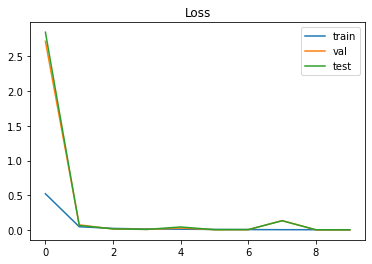

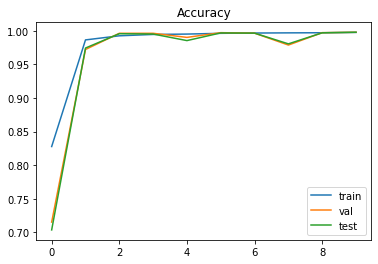

In [88]:
# Train model
train(model, loaders, optimizer, criterion, epochs=10, dev=dev)

In [ ]:
import torch.nn as nn

class MyCNN(nn.Module):

  #Constructor
  def __init__(self, in_size=3, out_size=10, use_norm=False):
    # Call parent contructor
    super().__init__()
    self.layers = nn.Sequential(
      # Layer 1
      nn.Conv2d(in_channels=in_size, out_channels=64, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      # Layer 2
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Layer 3
      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Layer 4
      nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Layer 5
      nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.AdaptiveMaxPool2d(output_size=2),
      # Classifier
      nn.Conv2d(in_channels=512, out_channels=out_size, kernel_size=2, padding=0, stride=1)
    )

  # Forward
  def forward(self, x):
    b, _, _, _ = x.shape
    output = self.layers(x)
    print(output)
    return output.view(b, -1)

In [ ]:
net = MyCNN()
x = torch.rand(3, 3, 32, 32)
out = net(x)
print(out)
print(out.shape)

tensor([[[[ 0.0320]],

         [[-0.0177]],

         [[-0.0154]],

         [[ 0.0203]],

         [[ 0.0083]],

         [[-0.0131]],

         [[ 0.0057]],

         [[-0.0138]],

         [[ 0.0431]],

         [[ 0.0291]]],


        [[[ 0.0315]],

         [[-0.0169]],

         [[-0.0153]],

         [[ 0.0193]],

         [[ 0.0078]],

         [[-0.0146]],

         [[ 0.0062]],

         [[-0.0157]],

         [[ 0.0422]],

         [[ 0.0279]]],


        [[[ 0.0313]],

         [[-0.0171]],

         [[-0.0146]],

         [[ 0.0196]],

         [[ 0.0069]],

         [[-0.0144]],

         [[ 0.0062]],

         [[-0.0138]],

         [[ 0.0432]],

         [[ 0.0280]]]], grad_fn=<MkldnnConvolutionBackward0>)
tensor([[ 0.0320, -0.0177, -0.0154,  0.0203,  0.0083, -0.0131,  0.0057, -0.0138,
          0.0431,  0.0291],
        [ 0.0315, -0.0169, -0.0153,  0.0193,  0.0078, -0.0146,  0.0062, -0.0157,
          0.0422,  0.0279],
        [ 0.0313, -0.0171, -0.0146,  0.0196,  0.0

In [ ]:
import matplotlib.pyplot as plt

def train(net, loaders, optimizer, criterion, epochs=100, device=torch.device('cpu')):
    try:
        net = net.to(device)
        # Initialize history
        history_loss = {"train": [], "test": []}
        history_accuracy = {"train": [], "test": []}
        # Process each epoch
        for epoch in range(epochs):
            print(f"Running epoch: {epoch}")
            # Initialize epoch variables
            sum_loss = {"train": 0, "test": 0}
            sum_accuracy = {"train": 0, "test": 0}
            # Process each split
            for split in ["train", "test"]:
                if split == "test":
                    net.eval()
                else:
                    net.train()
                # Process each batch
                for (input, labels) in tqdm(loaders[split],desc=split):
                    # Move to CUDA
                    input = input.to(device)
                    labels = labels.to(device)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = net(input)
                    loss = criterion(pred, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    _,pred_labels = pred.max(1)
                    batch_accuracy = (pred_labels == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "test"]}
            # Update history
            for split in ["train", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

Running epoch: 0


train:   0%|          | 0/1562 [00:00<?, ?it/s]

test:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: TrL=2.2468, TrA=0.1742, TeL=2.0451, TeA=0.2577,
Running epoch: 1


train:   0%|          | 0/1562 [00:00<?, ?it/s]

test:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: TrL=1.9052, TrA=0.3073, TeL=1.7384, TeA=0.3727,
Running epoch: 2


train:   0%|          | 0/1562 [00:00<?, ?it/s]

test:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: TrL=1.6377, TrA=0.4061, TeL=1.5279, TeA=0.4372,
Running epoch: 3


train:   0%|          | 0/1562 [00:00<?, ?it/s]

test:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: TrL=1.4959, TrA=0.4624, TeL=1.4543, TeA=0.4661,
Running epoch: 4


train:   0%|          | 0/1562 [00:00<?, ?it/s]

test:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: TrL=1.3945, TrA=0.5008, TeL=1.3499, TeA=0.5120,
Running epoch: 5


train:   0%|          | 0/1562 [00:00<?, ?it/s]

test:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6: TrL=1.3051, TrA=0.5350, TeL=1.2777, TeA=0.5404,
Running epoch: 6


train:   0%|          | 0/1562 [00:00<?, ?it/s]

test:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7: TrL=1.2112, TrA=0.5713, TeL=1.1852, TeA=0.5818,
Running epoch: 7


train:   0%|          | 0/1562 [00:00<?, ?it/s]

Interrupted


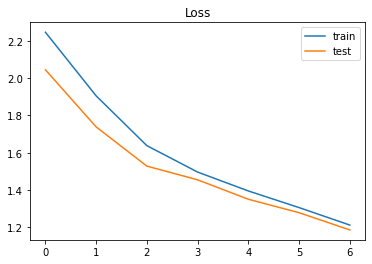

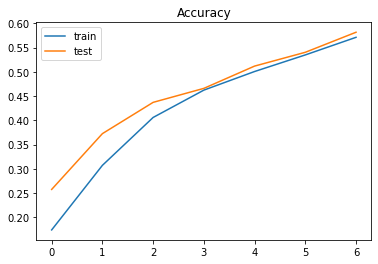

In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

net = MyCNN()
optimizer = optim.SGD(net.parameters(), lr = 0.005)
criterion = nn.CrossEntropyLoss()

train_dset = MyCifar10Dataset(dest_dir, train=True, transforms=transforms)
test_dset = MyCifar10Dataset(dest_dir, train=False, transforms=transforms)

train_loader = DataLoader(train_dset, batch_size=32, shuffle=True, drop_last=True, num_workers=2)
test_loader = DataLoader(test_dset, batch_size=32, shuffle=False, drop_last=False, num_workers=2)

# Define dictionary of loaders
loaders = {"train": train_loader,
           "test": test_loader}

train(net, loaders, optimizer, criterion, epochs=100, device=device)